# Solving underdetermined linear problems

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In this notebook, we'll explore how to solve simple underdetermined linear problems using the python package [cvxpy](https://www.cvxpy.org/index.html).
This package is dedicated to solving [convex optimization problems](https://en.wikipedia.org/wiki/Convex_optimization).
It allows you to express your problem in a fairly natural way that follows the math.
**cvxpy** then does all the hard work behind the scene to convert your problem into the restrictive standard form required by the numerical solvers.

## Synthetic problem

Before discussing how underdetermined systems of equations can be used to model certain engineering situations, let us illustrate how to solve them with **cvxpy**.
For that purpose, we'll consider a simple underdetermined problem

$$
\mathbf{Ax} = \mathbf{b}
$$

with $\mathbf{A} \in \mathbb{R}^{2 \times 20}$ a randomly generated matrix and $\mathbf{b} \in \mathbb{R}^2$ a random vector.
Our goal is to illustrate how different preconpcetions about the properties of the solution lead to vastly different solutions.
The cell below shows how to create these synthetic data.

In [2]:
# --> Size of the problem.
m, n = 2, 20

# --> Matrix A and vector b.
A = np.random.randn(m, n)
b = np.random.randn(m)

Because we have only two equations for twenty unknowns, the problem is underdetermined and admits an infinite number of solutions.
As discussed during the class, one way to pick one solution among this infinite set is to formulate an optimization problem.
For the sake of simplicity, we'll consider an optimization problem of the form

$$
\begin{aligned}
\textrm{minimize} \quad & \| \mathbf{x} \|_p \\
\textrm{subject to} \quad & \mathbf{Ax} = \mathbf{b},
\end{aligned}
$$

where $\| \mathbf{x} \|_p = \sqrt[p]{\sum_{i=1}^n \vert x_i \vert^p}$ is the $p$-norm of $\mathbf{x}$.
Provided $p \geq 1$, this problem is **convex** and can be efficiently solved with **cvxpy**.
Classically, we choose $p$ to be equal to $1$, $2$ or $\infty$.
Each of these choices leads to solutions having different properties
- $p = 1$ correponds to minimizing the $\ell_1$ norm. 
It tends to favor solutions wich are **sparse**, i.e. solution with most of its entries $x_i$ being equal to zero.
In terms of control, this often corresponds to a fuel-efficient control.
- $p = 2$ corresponds to minimizing the $\ell_2$ norm.
It tends to favor solutions whose entries are small on average.
In terms of control, this often corresponds to an energy-efficient control.
- $p = \infty$ corresponds to minimizing the $\ell_{\infty}$ norm, i.e. $\displaystyle \max_i \vert x_i \vert$.
It often corresponds to situation where $\mathbf{x}$ has to be bounded.

All these different variations of our optimization problem can be implemented using a single Python function as shown below.

In [3]:
def solve(A, b, p=2):
    # --> Get shape of the problem.
    m, n = A.shape
    
    # --> Define optimization variable.
    x = cp.Variable(n)
    
    # --> Objective function.
    objective = cp.Minimize(cp.norm(x, p))
    
    # --> Constraints.
    constraints = [ A @ x == b ]
    
    # --> Define the optimization problem and solve it.
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    return x.value

Choosing which version will be solved depends on the choice of the input argument `p`:
- `p = 1` is the $\ell_1$ norm minimization,
- `p = 2` is the $\ell_2$ norm minimization,
- `p = 'inf'` is the $\ell_{\infty}$ norm minimization.

By default, we set `p = 2` as this corresponds to most usage.
The next few cells illustrate how the solution changes as we vary the norm we aim to minimize.

In [4]:
# --> Least-norm solution.
x = solve(A, b, p=2)

<StemContainer object of 3 artists>

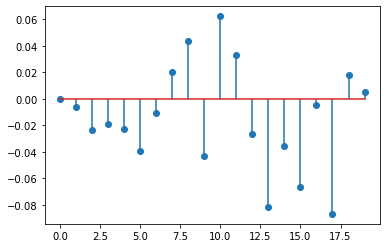

In [5]:
# --> Plot the solution.
plt.stem(x)

In [6]:
# --> Verify that it satisties the constraints to machine precision.
np.allclose(0, A @ x - b)

True

In [7]:
# --> Least-absolute norm solution.
x = solve(A, b, p=1)

<StemContainer object of 3 artists>

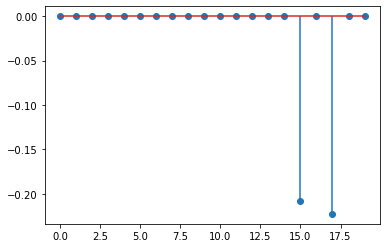

In [8]:
# --> Plot the solution.
plt.stem(x)

In [9]:
# --> Verify that it satisifies the constraints to machine precision.
np.allclose(0, A @ x - b)

True

In [10]:
# --> Least-max norm solution.
x = solve(A, b, p="inf")

<StemContainer object of 3 artists>

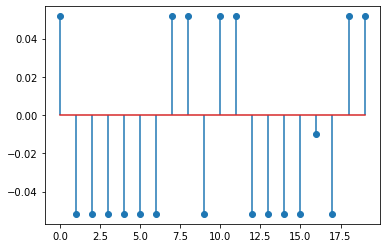

In [11]:
# --> Plot the solution.
plt.stem(x)

In [12]:
# --> Verifiy it satisfies the constraints to machine precision.
np.allclose(0, A @ x - b)

True

As you can see, all the different optimization problems lead to solutions satisifying the original $\mathbf{Ax} = \mathbf{b}$ equations.
They are however vastly different.
Which solution is the best is obviously application-dependent.
This is pretty much as far as maths can get you and where expert knowledge is required.

---

## A simple control problem

Consider the problem of moving a frictionless mobile of unit mass initially resting at $x=0$ to the position $x=1$ with $v = 0$ by time $t = \tau$.
We'll assume that the governing equations are given by

$$
\begin{aligned}
    \dot{x} & = v \\
    \dot{v} & = u
\end{aligned}
$$

where $u(t)$ is the control input we aim to design.
For the sake of simplicity, we'll assume that $u(t)$ is piecewise constant over a time-interval $\Delta t$.
Doing so, we can approximate our original continuous-time system by the following discrete-time one

$$
\begin{bmatrix}
x_{k+1} \\ v_{k+1}
\end{bmatrix}
=
\begin{bmatrix}
1 & \Delta t \\
0 & 1
\end{bmatrix}
\begin{bmatrix}
x_{k} \\ v_{k}
\end{bmatrix}
+
\begin{bmatrix}
0 \\ \Delta t
\end{bmatrix}
u_k.
$$

This system is of the general form

$$
\begin{aligned}
    \mathbf{x}_{k+1} & = \mathbf{Ax}_k + \mathbf{Bu}_k \\
    \mathbf{y}_k & = \mathbf{Cx}_k + \mathbf{Du}_k
\end{aligned}
$$

where $\mathbf{x} \in \mathbb{R}^2$ is the state of the system and $\mathbf{A} \in \mathbb{R}^{2 \times 2}$ is the dynamics matrix.
The matrices $\mathbf{B} \in \mathbb{R}^{2 \times 1}$, $\mathbf{C} \in \mathbb{R}^{2 \times 2}$ and $\mathbf{D} \in \mathbb{R}^{2 \times 1}$ are the **input-to-state**, **state-to-output** and **input-to-output** matrices.
For the sake of simplicity, we'll assume that
- $\mathbf{C} = \mathbf{I}_{2 \times 2}$ : we measure both the position and velocity at every time step.
- $\mathbf{D} = \mathbf{0}_{2 \times 1}$ : the input $u$ has no direct influence on our measurements.

We'll also assume that $\Delta t = 0.01$ non-dimensional time-unit.
The function below builds these matrices.

In [13]:
def build_system_matrices(Δt):
    # --> Dynamics matrix.
    A = np.array([[1.0, Δt], [0, 1]])
    
    # --> Input-to-state matrix.
    B = np.array([[0.0], [Δt]])
    
    # --> Measurement matrix (state-to-output)
    C = np.eye(2)
    
    # --> Input-to-output matrix.
    D = np.zeros((2, 1))
    
    return A, B, C, D

# --> Time-step discretization.
Δt = 0.01

# --> Get the matrices describing the system.
A, B, C, D = build_system_matrices(Δt)

Starting from $\mathbf{x} = \begin{bmatrix} 0 & 0 \end{bmatrix}^T$ at $t = 0$, our goal is to drive the system such that the output $\mathbf{y}$ at time $t = \tau$ is equal to

$$
\mathbf{y}(\tau) = \mathbf{Cx}(\tau) = \begin{bmatrix} 1 \\ 0 \end{bmatrix}.
$$

The cell below implements this final condition.

In [14]:
# --> Final position to reach.
y_end = np.array([1.0, 0.0])

Since we assume $u(t)$ to be piecewise constant, i.e. u(t) is constant over intervals of size $\Delta t$, we have $N = \tau / \Delta t$ values to determine.
Our control knob is thus a vector $\mathbf{u}$ of dimension $N \times 1$.
In order to formulate our control problem as an underdetermined system, we need find a mapping from this control sequence $\mathbf{u}$ to the final condition $\mathbf{y}(\tau) = \mathbf{y}(N \Delta t) = \mathbf{y}_N$, i.e.

$$
\mathbf{y}_N = \mathbf{Hu}
$$

with $\mathbf{H} \in \mathbb{R}^{2 \times N}$.
The question is thus **how to determine this matrix** $\mathbf{H}$?

To do so, let us consider the first few evolution steps.
Starting from $\mathbf{x}_0 = \mathbf{0}$, we can write

$$
\begin{aligned}
& \mathbf{x}_1 = \mathbf{Ax}_0 + \mathbf{B}u_0 = \mathbf{B}u_0 \quad \text{and} \quad \mathbf{y}_1 = \mathbf{Cx}_1 = \mathbf{CB}u_0 \\
& \mathbf{x}_2 = \mathbf{Ax}_1 + \mathbf{B}u_1 = \mathbf{AB}u_0 + \mathbf{B}u_1 \quad \text{and} \quad \mathbf{y}_2 = \mathbf{Cx}_2 = \mathbf{CAB}u_0 + \mathbf{CB}u_1 \\
& \mathbf{x}_3 = \mathbf{Ax}_2 + \mathbf{B}u_2 = \mathbf{A}^2 \mathbf{B}u_0 + \mathbf{AB}u_1 + \mathbf{B}u_2 \quad \text{and} \quad \mathbf{y}_3 = \mathbf{Cx}_3 = \mathbf{CA}^2 \mathbf{B}u_0 + \mathbf{CAB}u_1 + \mathbf{CB}u_2
\end{aligned}
$$

From there, it is easy to see that

$$
\mathbf{y}_N = \sum_{k=1}^N \mathbf{CA}^{k-1} \mathbf{B}u[k-1].
$$

Alternatively, this can be written as

$$
\mathbf{y}_N = \mathbf{Hu}
$$

where the k<sup>th</sup> column of $\mathbf{H}$ is given by $\mathbf{H}_k = \mathbf{CA}^{k-1}\mathbf{B}$.
This matrix is computed below.

In [15]:
# --> Time to reach + number of time-steps to take.
τ = 1.0
N = int(τ / Δt)

# --> Construct the input-to-state matrix.
H = np.hstack([C @ np.linalg.matrix_power(A, k-1) @ B for k in range(1, N+1)])[:, ::-1]

We now have everything we need to design our control.
The control sequence is thus determined as the solution to the following optimization problem

$$
\begin{aligned}
\textrm{minimize} \quad & \| \mathbf{u} \|_p \\
\textrm{subject to} \quad & \mathbf{Hu} = \mathbf{y}_N.
\end{aligned}
$$

Depeding on the choice for $p$, we'll obtain different control strategies.
The next few cells solve this optimization problem, simulate the corresponding evolution of the system and plot the corresponding time-series of $u(t)$, $v(t)$ and $x(t)$.
Do not hesitate to change `p` to see how the control input changes.

In [24]:
# --> Solve for the control input sequence to be applied.
#     p = 2 --> least-norm solution (i.e. energy optimal).
#     p = 1 --> least-absolute norm solution (i.e. fuel optimal)
#     p = "inf" --> least-infinite norm solution.
u = solve(H, y_end, p=2)

print("L1 norm of the solution :", np.linalg.norm(u, 1))
print("L2 norm of the solution :", np.linalg.norm(u, 2))
print("L_inf norm of the solution :", np.linalg.norm(u, np.inf))

L1 norm of the solution : 300.0300030003031
L2 norm of the solution : 34.64274833209974
L_inf norm of the solution : 5.940594059406068


In [25]:
# --> SciPy utility functions for discrete-time linear systems.
from scipy.signal import dlti, dlsim

# --> Define the system.
dynsys = dlti(A, B, C, D)

# --> Simulation the system with the control sequence just computed.
u = np.append(u, 0)
steps, y, x = dlsim(dynsys, u)

In [26]:
# --> Verify that last output is consistent with our goal.
np.allclose(y[-1], y_end)

True

[(-0.01, 1.01), (0.0, 1.0)]

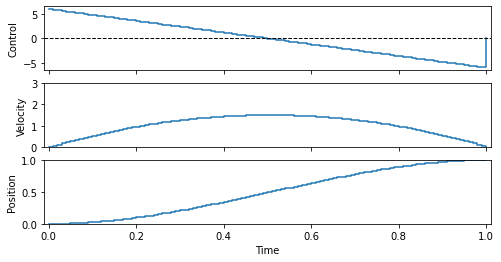

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(8, 4), sharex=True)
ax[0].step(Δt*steps, u, where="post")
ax[0].set_ylabel("Control")
ax[0].axhline(0, c="k", ls="--", lw=1)

ax[1].step(Δt*steps, x[:, 1], where="post")
ax[1].set_ylabel("Velocity")
ax[1].set_ylim(0, 3)

ax[2].step(Δt*steps, x[:, 0], where="post")
ax[2].set_ylabel("Position")
ax[2].set_xlabel("Time")
ax[2].set(xlim=(-Δt, τ+Δt), ylim=(0, 1))